In [ ]:
!pip install torch torchvision matplotlib opencv-python timm tqdm

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

drive_dir = """/content/drive/MyDrive/KoreaUniv/2024/DEEP_LEARNING/Final_Project"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## dataset

In [ ]:
data_dir = drive_dir + "/datasets/Office-31/domain_adaptation_images"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
batch_size = 32
learning_rate = 1e-4
num_epochs = 20

In [ ]:
amazon_dir = data_dir + '/amazon/images'
dslr_dir = data_dir + '/dslr/images'
webcam_dir = data_dir + '/webcam/images'

amazon_dataset = datasets.ImageFolder(root=amazon_dir, transform=transform)
dslr_dataset = datasets.ImageFolder(root=dslr_dir, transform=transform)
webcam_dataset = datasets.ImageFolder(root=webcam_dir, transform=transform)

amazon_loader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True)
dslr_loader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=True)
webcam_loader = DataLoader(webcam_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
classes = amazon_dataset.classes

### visualize samples

In [ ]:
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 해제!!
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

In [ ]:
def visualize_samples(dataloader, domain_name, classes, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    plt.figure(figsize=(15, 5))
    for idx in range(num_images):
        plt.subplot(1, num_images, idx+1)
        imshow(images[idx], title=f"{domain_name} - {classes[int(labels[idx])]}[{labels[idx]}]")
    plt.show()

Visualizing Amazon Samples


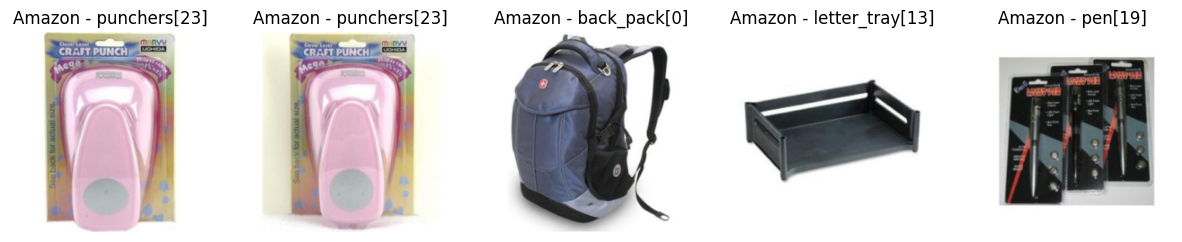

Visualizing DSLR Samples...


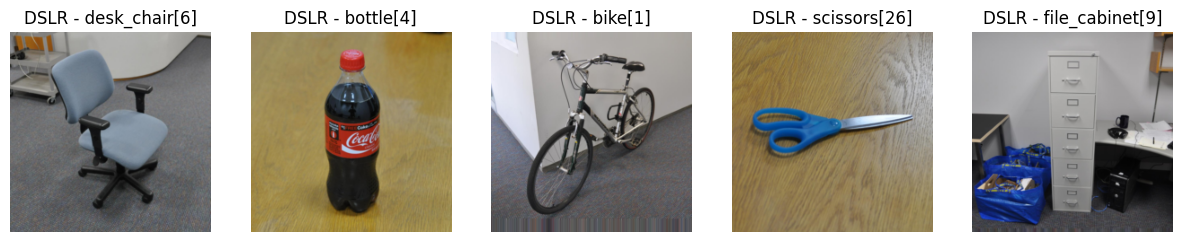

Visualizing Webcam Samples


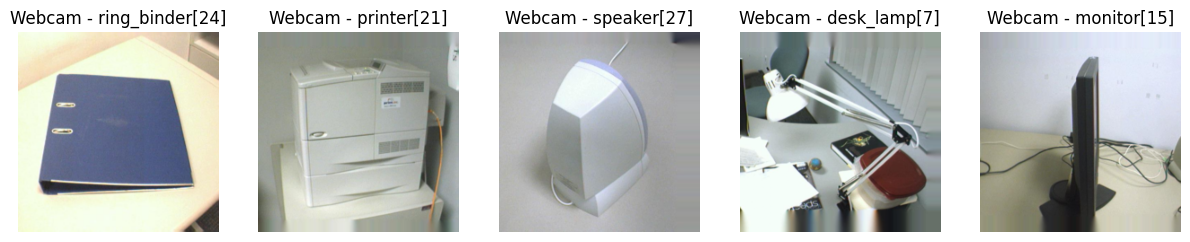

In [ ]:
print("Visualizing Amazon Samples")
visualize_samples(amazon_loader, domain_name="Amazon", classes=classes)

print("Visualizing DSLR Samples...")
visualize_samples(dslr_loader, domain_name="DSLR", classes=classes)

print("Visualizing Webcam Samples")
visualize_samples(webcam_loader, domain_name="Webcam", classes=classes)

## ViT Domain Adaptation

### Model

In [ ]:
class ViTDomainAdaptation(nn.Module):
    def __init__(self, num_classes):
        super(ViTDomainAdaptation, self).__init__()
        self.feature_extractor = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        outputs = self.fc(features)
        return features, outputs

In [ ]:
def coral_loss(source, target):
    d = source.size(1)
    source_cov = torch.mm(source.T, source) / source.size(0)
    target_cov = torch.mm(target.T, target) / target.size(0)
    loss = torch.norm(source_cov - target_cov, p="fro") ** 2 / (4 * d * d)
    return loss

### Training

In [ ]:
def train_model(model, source_loader, target_loader, domain_pair, num_epochs, learning_rate):
    print(f"Train {domain_pair[0]} -> {domain_pair[1]}")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    classification_loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_class_loss, total_coral_loss = 0, 0, 0

        source_iter = iter(source_loader)
        target_iter = iter(target_loader)

        for _ in tqdm(range(min(len(source_loader), len(target_loader)))):
            source_data, source_labels = next(source_iter)
            target_data, _ = next(target_iter)

            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)

            source_features, source_preds = model(source_data)
            target_features, _ = model(target_data)

            class_loss = classification_loss(source_preds, source_labels)
            domain_loss = coral_loss(source_features, target_features)

            # Trade-off parameter
            loss = class_loss + 0.1 * domain_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_coral_loss += domain_loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}, Class Loss: {total_class_loss:.4f}, Coral Loss: {total_coral_loss:.4f}")

### Evaluating

In [ ]:
def evaluate_model(model, target_loader, domain_pair):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, labels in target_loader:
            data, labels = data.to(device), labels.to(device)
            _, outputs = model(data)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    print(f"Accuracy of {domain_pair[0]} model on {domain_pair[1]} domain: {100 * correct / total:.2f}%")

### Visualize results

In [ ]:
# predicted samples
def visualize_predictions(model, dataloader, device, classes, num_images=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                plt.subplot(1, num_images, images_shown + 1)
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = img / 2 + 0.5
                plt.imshow(img)
                plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

In [ ]:
# confusion matrix
def plot_confusion_matrix(model, dataloader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def show_results(model, source_loader, target_loader, domain_pair, device, classes):
    print(f"Visualizing {domain_pair[0]} model on {domain_pair[1]} domain")
    visualize_predictions(model, target_loader, device, classes, num_images=5)

    evaluate_model(model, source_loader, domain_pair)
    plot_confusion_matrix(model, source_loader, device, classes)

    evaluate_model(model, target_loader, domain_pair)
    plot_confusion_matrix(model, target_loader, device, classes)

### experiment set

In [ ]:
def construct_experiment(model,source_loader, target_loader, domain_pair, device, num_epochs, learning_rate):
    print(f"{domain_pair[0]} model on {domain_pair[1]} domain")
    train_model(model, source_loader, target_loader, domain_pair, num_epochs, learning_rate)
    show_results(model, source_loader, target_loader, domain_pair, device, classes)

## Experiment

### Amazon

In [ ]:
# Amazon
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)

Amazon model on DSLR domain
Train Amazon -> DSLR


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [1/20], Total Loss: 30.6729, Class Loss: 30.3913, Coral Loss: 2.8158


100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


Epoch [2/20], Total Loss: 11.5766, Class Loss: 11.2789, Coral Loss: 2.9775


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [3/20], Total Loss: 10.0880, Class Loss: 9.8938, Coral Loss: 1.9421


100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


Epoch [4/20], Total Loss: 7.4746, Class Loss: 7.3003, Coral Loss: 1.7432


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Epoch [5/20], Total Loss: 7.6834, Class Loss: 7.5164, Coral Loss: 1.6700


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [6/20], Total Loss: 4.2361, Class Loss: 3.9868, Coral Loss: 2.4927


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [7/20], Total Loss: 5.4313, Class Loss: 5.2067, Coral Loss: 2.2463


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [8/20], Total Loss: 4.4015, Class Loss: 4.1702, Coral Loss: 2.3133


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [9/20], Total Loss: 3.2945, Class Loss: 3.0827, Coral Loss: 2.1182


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [10/20], Total Loss: 3.5047, Class Loss: 3.2783, Coral Loss: 2.2645


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [11/20], Total Loss: 3.6441, Class Loss: 3.4318, Coral Loss: 2.1234


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [12/20], Total Loss: 2.9525, Class Loss: 2.7684, Coral Loss: 1.8403


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [13/20], Total Loss: 3.4135, Class Loss: 3.2409, Coral Loss: 1.7252


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [14/20], Total Loss: 1.8843, Class Loss: 1.7015, Coral Loss: 1.8279


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [15/20], Total Loss: 1.5800, Class Loss: 1.4127, Coral Loss: 1.6729


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Epoch [16/20], Total Loss: 1.4129, Class Loss: 1.1982, Coral Loss: 2.1469


100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


Epoch [17/20], Total Loss: 1.7367, Class Loss: 1.5441, Coral Loss: 1.9259


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [18/20], Total Loss: 1.5952, Class Loss: 1.4270, Coral Loss: 1.6829


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [19/20], Total Loss: 0.8873, Class Loss: 0.6703, Coral Loss: 2.1700


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [20/20], Total Loss: 1.4632, Class Loss: 1.2644, Coral Loss: 1.9885
Visualizing Amazon model on DSLR domain


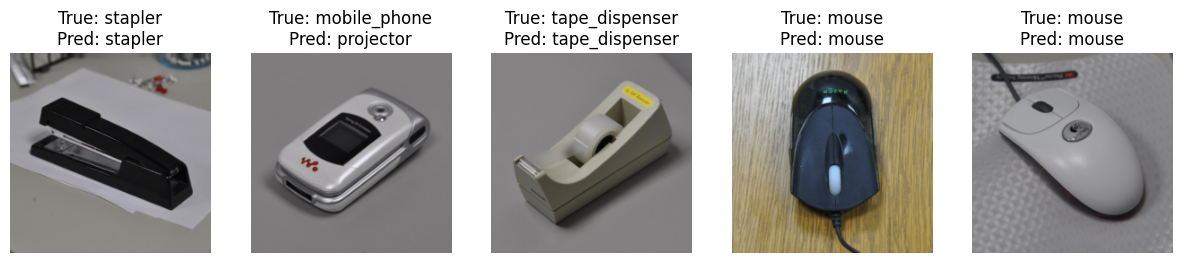

Accuracy of Amazon model on DSLR domain: 98.19%


<Figure size 1000x800 with 0 Axes>

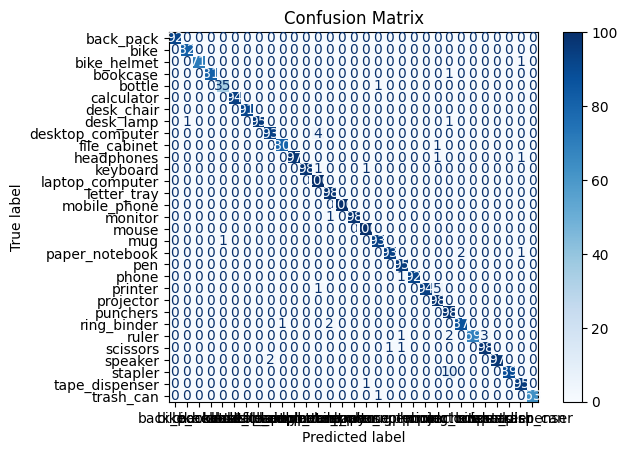

Accuracy of Amazon model on DSLR domain: 74.70%


<Figure size 1000x800 with 0 Axes>

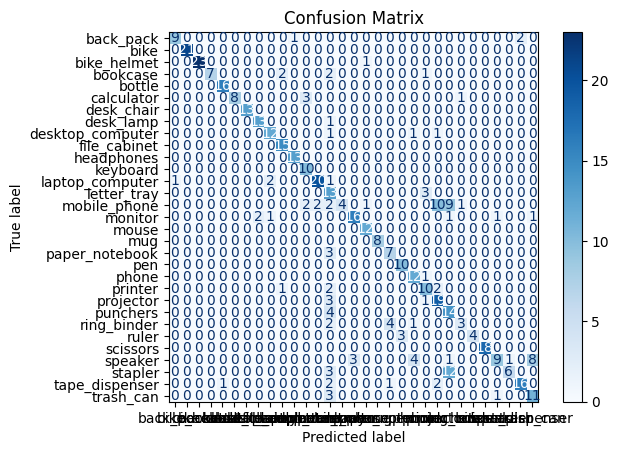

In [ ]:
construct_experiment(model, amazon_loader, dslr_loader, ("Amazon", "DSLR"), device, num_epochs, learning_rate)

Amazon model on Webcam domain
Train Amazon -> Webcam


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


Epoch [1/20], Total Loss: 41.4386, Class Loss: 41.0413, Coral Loss: 3.9737


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [2/20], Total Loss: 13.9753, Class Loss: 13.5310, Coral Loss: 4.4433


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [3/20], Total Loss: 9.4579, Class Loss: 9.1282, Coral Loss: 3.2968


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [4/20], Total Loss: 7.7524, Class Loss: 7.4373, Coral Loss: 3.1505


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [5/20], Total Loss: 6.2350, Class Loss: 5.9130, Coral Loss: 3.2190


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [6/20], Total Loss: 6.1885, Class Loss: 5.8442, Coral Loss: 3.4426


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [7/20], Total Loss: 4.3217, Class Loss: 4.0003, Coral Loss: 3.2150


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [8/20], Total Loss: 2.6578, Class Loss: 2.3267, Coral Loss: 3.3117


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [9/20], Total Loss: 4.0358, Class Loss: 3.6988, Coral Loss: 3.3696


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [10/20], Total Loss: 3.1167, Class Loss: 2.8328, Coral Loss: 2.8393


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [11/20], Total Loss: 3.6136, Class Loss: 3.3067, Coral Loss: 3.0688


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [12/20], Total Loss: 3.2891, Class Loss: 3.0355, Coral Loss: 2.5363


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [13/20], Total Loss: 2.8647, Class Loss: 2.6090, Coral Loss: 2.5571


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [14/20], Total Loss: 2.2094, Class Loss: 1.9308, Coral Loss: 2.7856


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [15/20], Total Loss: 2.3986, Class Loss: 2.1287, Coral Loss: 2.6991


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [16/20], Total Loss: 2.2125, Class Loss: 1.9380, Coral Loss: 2.7444


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Epoch [17/20], Total Loss: 1.8126, Class Loss: 1.5829, Coral Loss: 2.2968


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [18/20], Total Loss: 3.0693, Class Loss: 2.8326, Coral Loss: 2.3667


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [19/20], Total Loss: 1.6155, Class Loss: 1.3928, Coral Loss: 2.2273


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [20/20], Total Loss: 1.7650, Class Loss: 1.5556, Coral Loss: 2.0942
Visualizing Amazon model on Webcam domain


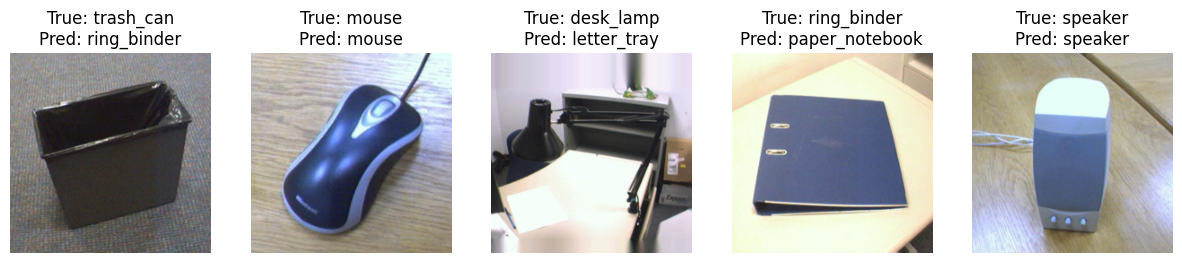

Accuracy of Amazon model on Webcam domain: 98.97%


<Figure size 1000x800 with 0 Axes>

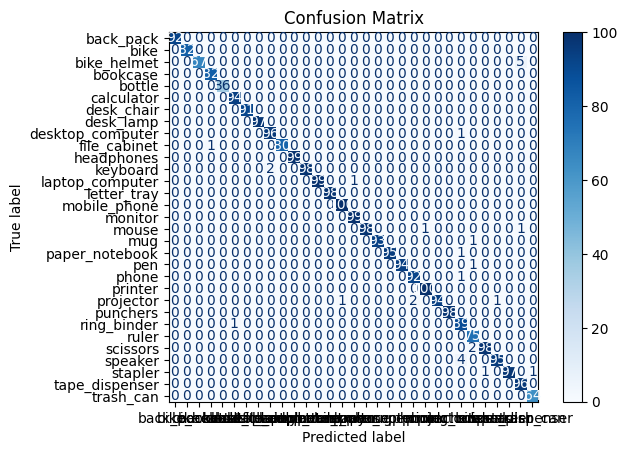

Accuracy of Amazon model on Webcam domain: 68.55%


<Figure size 1000x800 with 0 Axes>

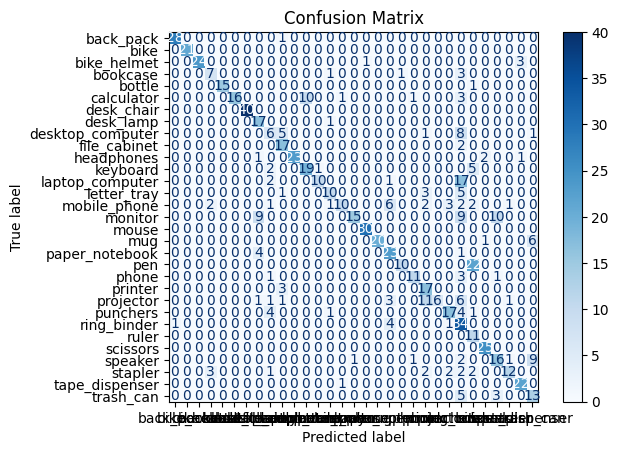

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, amazon_loader, webcam_loader, ("Amazon", "Webcam"), device, num_epochs, learning_rate)

### DSLR

DSLR model on Amazon domain
Train DSLR -> Amazon


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [1/20], Total Loss: 17.7769, Class Loss: 17.2240, Coral Loss: 5.5296


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [2/20], Total Loss: 1.0420, Class Loss: 0.6092, Coral Loss: 4.3281


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [3/20], Total Loss: 0.3903, Class Loss: 0.1490, Coral Loss: 2.4133


100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


Epoch [4/20], Total Loss: 0.3102, Class Loss: 0.1181, Coral Loss: 1.9204


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [5/20], Total Loss: 0.2250, Class Loss: 0.0647, Coral Loss: 1.6035


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [6/20], Total Loss: 0.1639, Class Loss: 0.0422, Coral Loss: 1.2172


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [7/20], Total Loss: 0.1407, Class Loss: 0.0359, Coral Loss: 1.0484


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [8/20], Total Loss: 0.1285, Class Loss: 0.0320, Coral Loss: 0.9654


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [9/20], Total Loss: 0.1135, Class Loss: 0.0287, Coral Loss: 0.8486


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Epoch [10/20], Total Loss: 0.1044, Class Loss: 0.0254, Coral Loss: 0.7906


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [11/20], Total Loss: 0.0970, Class Loss: 0.0249, Coral Loss: 0.7211


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Epoch [12/20], Total Loss: 0.0882, Class Loss: 0.0208, Coral Loss: 0.6738


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [13/20], Total Loss: 0.0794, Class Loss: 0.0201, Coral Loss: 0.5927


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [14/20], Total Loss: 0.0774, Class Loss: 0.0185, Coral Loss: 0.5891


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [15/20], Total Loss: 0.0703, Class Loss: 0.0170, Coral Loss: 0.5329


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [16/20], Total Loss: 0.0642, Class Loss: 0.0154, Coral Loss: 0.4879


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [17/20], Total Loss: 0.0615, Class Loss: 0.0149, Coral Loss: 0.4669


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [18/20], Total Loss: 0.0590, Class Loss: 0.0136, Coral Loss: 0.4534


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Epoch [19/20], Total Loss: 0.0554, Class Loss: 0.0139, Coral Loss: 0.4143


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Epoch [20/20], Total Loss: 0.0501, Class Loss: 0.0117, Coral Loss: 0.3847
Visualizing DSLR model on Amazon domain


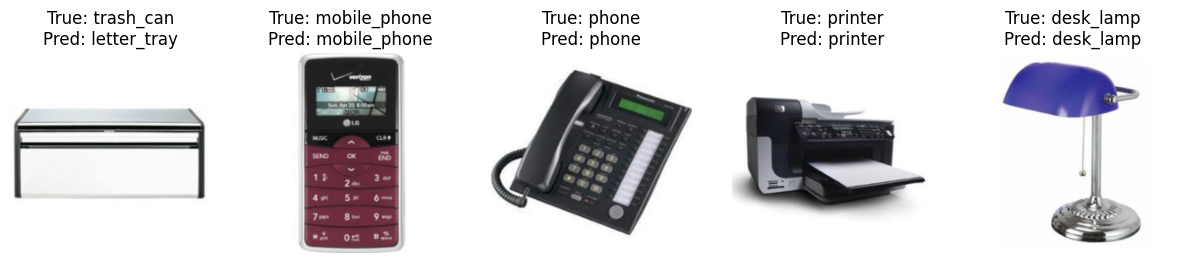

Accuracy of DSLR model on Amazon domain: 100.00%


<Figure size 1000x800 with 0 Axes>

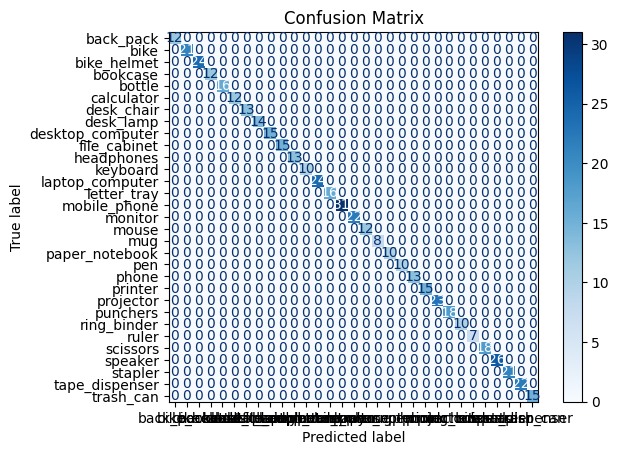

Accuracy of DSLR model on Amazon domain: 67.34%


<Figure size 1000x800 with 0 Axes>

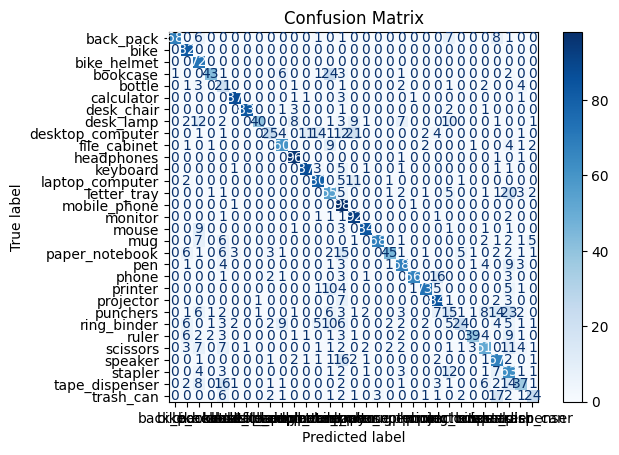

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, dslr_loader, amazon_loader, ("DSLR", "Amazon"), device, num_epochs, learning_rate)

DSLR model on Webcam domain
Train DSLR -> Webcam


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [1/20], Total Loss: 22.3998, Class Loss: 22.0116, Coral Loss: 3.8821


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [2/20], Total Loss: 1.6071, Class Loss: 1.1603, Coral Loss: 4.4682


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [3/20], Total Loss: 0.7556, Class Loss: 0.5011, Coral Loss: 2.5456


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [4/20], Total Loss: 0.4171, Class Loss: 0.2074, Coral Loss: 2.0975


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [5/20], Total Loss: 0.2493, Class Loss: 0.0655, Coral Loss: 1.8386


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [6/20], Total Loss: 0.1729, Class Loss: 0.0556, Coral Loss: 1.1735


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch [7/20], Total Loss: 0.1467, Class Loss: 0.0357, Coral Loss: 1.1093


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [8/20], Total Loss: 0.1355, Class Loss: 0.0335, Coral Loss: 1.0195


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [9/20], Total Loss: 0.1230, Class Loss: 0.0323, Coral Loss: 0.9073


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch [10/20], Total Loss: 0.1134, Class Loss: 0.0277, Coral Loss: 0.8578


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [11/20], Total Loss: 0.1024, Class Loss: 0.0259, Coral Loss: 0.7647


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [12/20], Total Loss: 0.0994, Class Loss: 0.0250, Coral Loss: 0.7436


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [13/20], Total Loss: 0.0902, Class Loss: 0.0225, Coral Loss: 0.6779


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [14/20], Total Loss: 0.0884, Class Loss: 0.0209, Coral Loss: 0.6746


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [15/20], Total Loss: 0.0823, Class Loss: 0.0207, Coral Loss: 0.6166


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [16/20], Total Loss: 0.0784, Class Loss: 0.0196, Coral Loss: 0.5881


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [17/20], Total Loss: 0.0725, Class Loss: 0.0167, Coral Loss: 0.5578


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [18/20], Total Loss: 0.0669, Class Loss: 0.0166, Coral Loss: 0.5029


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [19/20], Total Loss: 0.0672, Class Loss: 0.0159, Coral Loss: 0.5126


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [20/20], Total Loss: 0.0637, Class Loss: 0.0153, Coral Loss: 0.4840
Visualizing DSLR model on Webcam domain


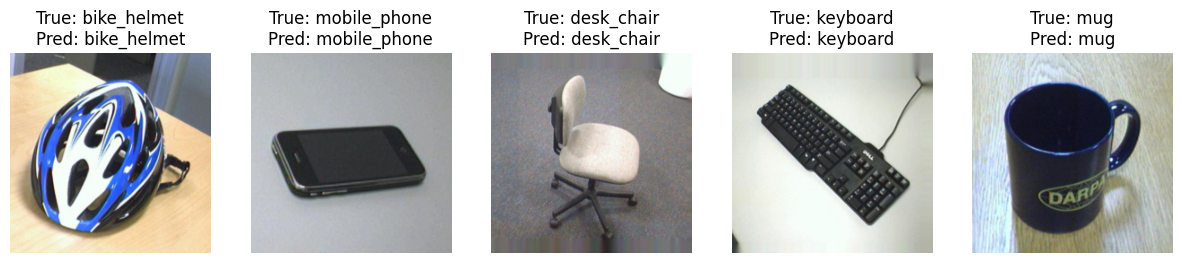

Accuracy of DSLR model on Webcam domain: 100.00%


<Figure size 1000x800 with 0 Axes>

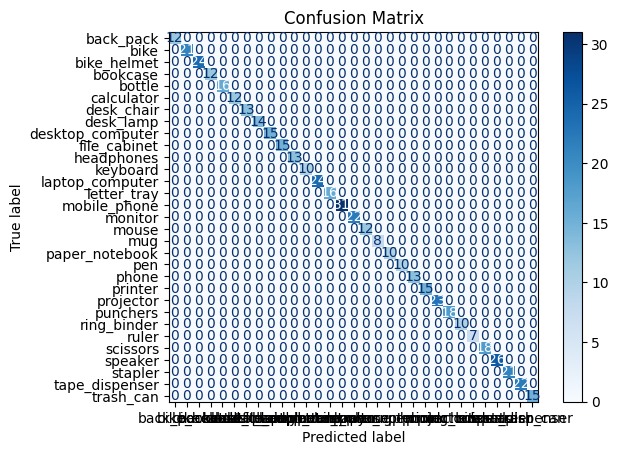

Accuracy of DSLR model on Webcam domain: 96.60%


<Figure size 1000x800 with 0 Axes>

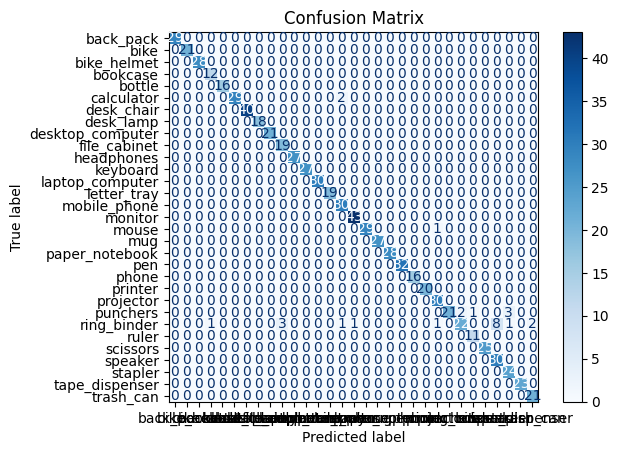

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, dslr_loader, webcam_loader, ("DSLR", "Webcam"), device, num_epochs, learning_rate)

### Webcam

Webcam model on Amazon domain
Train Webcam -> Amazon


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [1/20], Total Loss: 23.5426, Class Loss: 22.6415, Coral Loss: 9.0113


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [2/20], Total Loss: 1.2655, Class Loss: 0.7573, Coral Loss: 5.0822


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [3/20], Total Loss: 0.4427, Class Loss: 0.1655, Coral Loss: 2.7716


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [4/20], Total Loss: 0.2992, Class Loss: 0.0926, Coral Loss: 2.0658


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Epoch [5/20], Total Loss: 0.2216, Class Loss: 0.0571, Coral Loss: 1.6455


100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Epoch [6/20], Total Loss: 0.1859, Class Loss: 0.0477, Coral Loss: 1.3818


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [7/20], Total Loss: 0.1689, Class Loss: 0.0419, Coral Loss: 1.2696


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [8/20], Total Loss: 0.1507, Class Loss: 0.0383, Coral Loss: 1.1239


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [9/20], Total Loss: 0.1395, Class Loss: 0.0340, Coral Loss: 1.0547


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [10/20], Total Loss: 0.1264, Class Loss: 0.0304, Coral Loss: 0.9601


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [11/20], Total Loss: 0.1141, Class Loss: 0.0286, Coral Loss: 0.8546


100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


Epoch [12/20], Total Loss: 0.1022, Class Loss: 0.0254, Coral Loss: 0.7678


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [13/20], Total Loss: 0.0962, Class Loss: 0.0232, Coral Loss: 0.7301


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [14/20], Total Loss: 0.0904, Class Loss: 0.0217, Coral Loss: 0.6866


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [15/20], Total Loss: 0.0810, Class Loss: 0.0196, Coral Loss: 0.6148


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [16/20], Total Loss: 0.0773, Class Loss: 0.0190, Coral Loss: 0.5829


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [17/20], Total Loss: 0.0720, Class Loss: 0.0169, Coral Loss: 0.5511


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [18/20], Total Loss: 0.0690, Class Loss: 0.0165, Coral Loss: 0.5249


100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Epoch [19/20], Total Loss: 0.0626, Class Loss: 0.0151, Coral Loss: 0.4749


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Epoch [20/20], Total Loss: 0.0593, Class Loss: 0.0143, Coral Loss: 0.4502
Visualizing Webcam model on Amazon domain


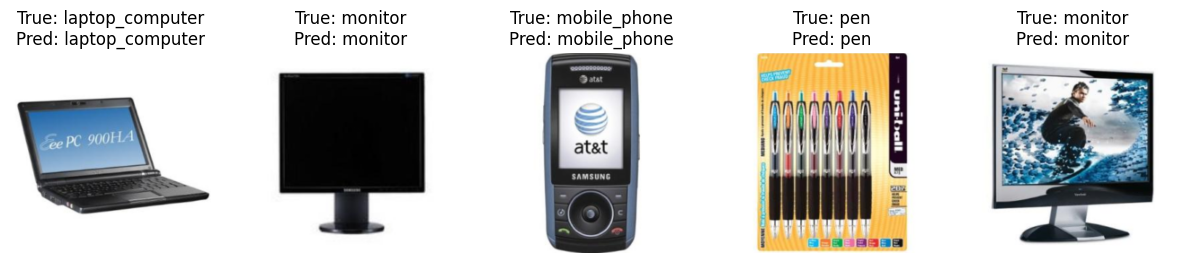

Accuracy of Webcam model on Amazon domain: 100.00%


<Figure size 1000x800 with 0 Axes>

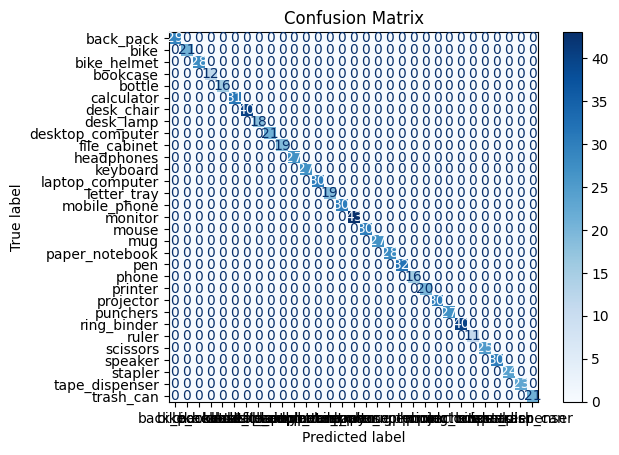

Accuracy of Webcam model on Amazon domain: 66.81%


<Figure size 1000x800 with 0 Axes>

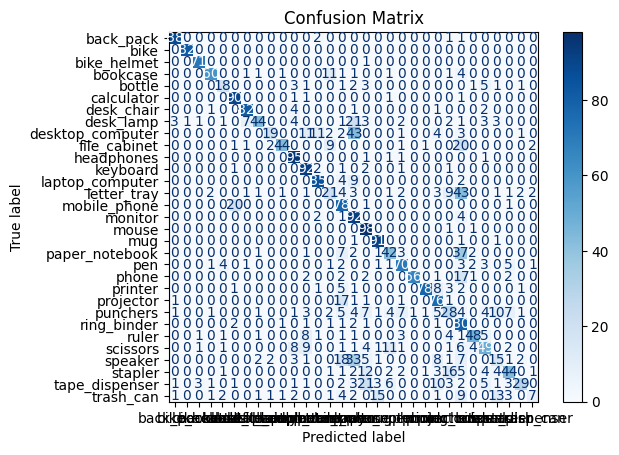

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, webcam_loader, amazon_loader, ("Webcam", "Amazon"), device, num_epochs, learning_rate)

Webcam model on DSLR domain
Train Webcam -> DSLR


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [1/20], Total Loss: 22.9340, Class Loss: 22.4120, Coral Loss: 5.2196


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [2/20], Total Loss: 2.4101, Class Loss: 1.7417, Coral Loss: 6.6840


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [3/20], Total Loss: 0.9680, Class Loss: 0.6618, Coral Loss: 3.0619


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [4/20], Total Loss: 0.6987, Class Loss: 0.3925, Coral Loss: 3.0619


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [5/20], Total Loss: 0.4896, Class Loss: 0.2716, Coral Loss: 2.1796


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [6/20], Total Loss: 0.4004, Class Loss: 0.1851, Coral Loss: 2.1535


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [7/20], Total Loss: 0.4338, Class Loss: 0.2331, Coral Loss: 2.0073


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [8/20], Total Loss: 0.4931, Class Loss: 0.3453, Coral Loss: 1.4780


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [9/20], Total Loss: 0.1951, Class Loss: 0.0650, Coral Loss: 1.3005


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [10/20], Total Loss: 0.1636, Class Loss: 0.0313, Coral Loss: 1.3231


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [11/20], Total Loss: 0.1279, Class Loss: 0.0333, Coral Loss: 0.9463


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [12/20], Total Loss: 0.1245, Class Loss: 0.0281, Coral Loss: 0.9642


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [13/20], Total Loss: 0.1115, Class Loss: 0.0277, Coral Loss: 0.8379


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [14/20], Total Loss: 0.1061, Class Loss: 0.0243, Coral Loss: 0.8176


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Epoch [15/20], Total Loss: 0.0957, Class Loss: 0.0230, Coral Loss: 0.7266


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [16/20], Total Loss: 0.0912, Class Loss: 0.0225, Coral Loss: 0.6875


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [17/20], Total Loss: 0.0828, Class Loss: 0.0187, Coral Loss: 0.6411


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [18/20], Total Loss: 0.0820, Class Loss: 0.0198, Coral Loss: 0.6227


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Epoch [19/20], Total Loss: 0.0701, Class Loss: 0.0177, Coral Loss: 0.5247


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch [20/20], Total Loss: 0.0683, Class Loss: 0.0160, Coral Loss: 0.5228
Visualizing Webcam model on DSLR domain


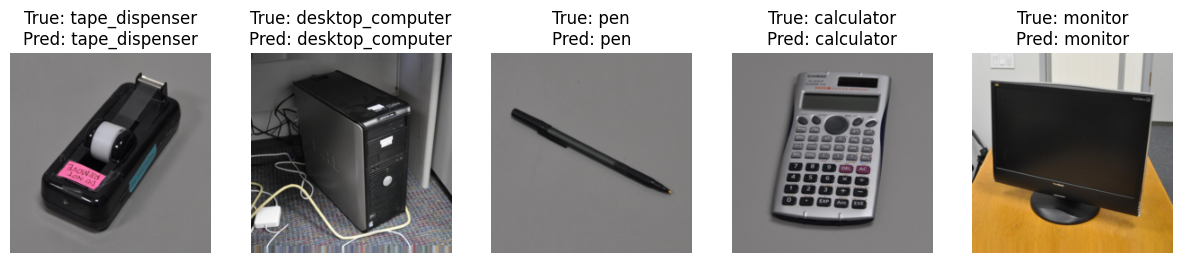

Accuracy of Webcam model on DSLR domain: 100.00%


<Figure size 1000x800 with 0 Axes>

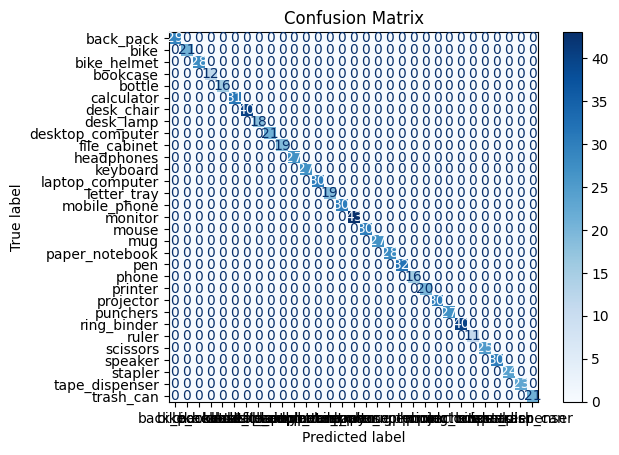

Accuracy of Webcam model on DSLR domain: 100.00%


<Figure size 1000x800 with 0 Axes>

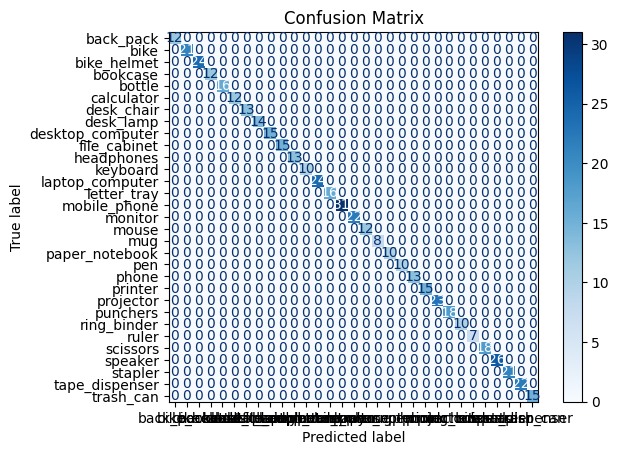

In [ ]:
model = ViTDomainAdaptation(num_classes=len(classes)).to(device)
construct_experiment(model, webcam_loader, dslr_loader, ("Webcam", "DSLR"), device, num_epochs, learning_rate)